In [2]:
def linearInterpolate(x, y, s):
    
    def getIndices(x,value):
        p = q = None        
        for i in range(len(x) - 1):
            if x[i] <= value and x[i + 1] >= value:
                p, q = i, i + 1
                break
        if p is None or q is None:
            raise ValueError("Suitable indices not found. s may be out of bounds.")
        return p,q

    if isinstance(s,np.ndarray):
        ys = np.zeros_like(s)
        for index, value in enumerate(s):
            if (value > x[0] and value < x[-1]):
                [p,q] = getIndices(x,value)
                # Linear interpolation
                ys[index] = y[p] + ((value - x[p]) * (y[q] - y[p])) / (x[q] - x[p])
    
    elif isinstance(s, float):
        value = s
        [p,q] = getIndices(x,value)
        ys = y[p] + ((value - x[p]) * (y[q] - y[p])) / (x[q] - x[p])
    
    return ys

def rotateFrame2D(sigmaXX, sigmaYY, sigmaXY, theta):
    
# Rotate frame of reference by theta_xy, stresses do not rotate.
# Normally used to visualize stresses in a frame of reference whose x-axis is
# aligned with the fault strike

# In soil mechanics convention, stress positive if compressive, shear on face
# parallel to x axis positive if counterclockwise
    
    Q = np.array([ [ np.cos(theta), np.sin(theta)],
                   [-np.sin(theta), np.cos(theta)] ])
    
    sigma_tensor = np.array([ [sigmaXX, sigmaXY],
                              [sigmaXY, sigmaYY] ])

    return Q@sigma_tensor@(Q.T)

In [240]:
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.signal import hilbert
import os
import csv
import matplotlib.gridspec as gridspec 
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from matplotlib.pyplot import MultipleLocator 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.major.size']  = 8
plt.rcParams['xtick.minor.size']  = 4
plt.rcParams['ytick.major.size']  = 8
plt.rcParams['ytick.minor.size']  = 4

separator = os.path.sep
AEs = [1,2,3,4]
slipAEs = [0.043, 0.051, 0.079, 0.095] # in cm; for E1-E4  430  
stressDiffAEs = [7.98, 8.10, 8.11, 8.11] # in MPa 

DeltaSigma_s = []
z1_diff_m_s = []
z1_diff_s_s   = []
z1_diff_ss_s  = []
z1_diff_sss_s = []
color_t_s_s   = []
color_t_ss_s  = []
color_t_sss_s = []
color_t_m_s = []

dists_s = []
areas_s = []

distss_s = []
areass_s = []

distsss_s = []
areasss_s = []

dist_m_s = []
area_m_s = []

times_s = []
timess_s = []
timesss_s = []
time_m_s = []

for AE in range(4):
    AEidx = str(AEs[AE])
    
    ####### AE data: time, distance, Magnitude  
    AE_data= sio.loadmat("AE_E" + AEidx + separator + "AEs.mat")["data"]  
    time=AE_data[0,:]
    
    ##  AE events, 30s before the instability
    inx = np.where(time>=-30)[0]
    time = time[inx]
    data = AE_data[:,inx]
    
    ##  division of magnitude, minimum values>1
    mags =np.round(data[2,:],1)
    inxs = np.where((mags>=0.9) & (mags<=1.9))[0]
    inxss = np.where((mags>=2.0) & (mags<=2.9))[0]
    inxsss = np.where((mags>=3.0) & (mags<=4.1))[0]
    
    area = (data[2,:]*1.2)**4.8
    
    #1<M<1.9
    times = time[inxs]
    dists = data[1, inxs]
    areas = area[inxs]
    
    #2.0<M<2.9
    timess = time[inxss]
    distss = data[1, inxss]
    areass = area[inxss]
    
    #3.0<M<3.9
    timesss = time[inxsss]
    distsss = data[1, inxsss]
    areasss = area[inxsss]
    
    ## 主震
    time_m = time[-1]
    dist_m = data[1,-1]
    area_m = area[-1]
    
    data=sio.loadmat("Roughness.mat")["data"]
    nn=400
    xx=data[:,0].reshape(nn,nn)
    yy=data[:,1].reshape(nn,nn)
    zz=data[:,2].reshape(nn,nn)
    
    x1=xx
    y1=yy
    z1=zz*1e-4 # conversion to cm
    
    ### profile derivatives and Hilbert transform
    x1_diff = x1[0,0:-1]+np.diff(x1[0,:])
    z1_diff = np.diff(np.mean(z1,axis=0)) # first derivative of profile
    
    x1_ddiff = x1_diff[0:-1]+np.diff(x1_diff)
    z1_ddiff = np.diff(z1_diff) #second derivative of profile
    analytical_signal = hilbert(z1_ddiff)
    hz1_ddiff = analytical_signal.imag # Hilbert transform of second derivative of the profile
    slip = slipAEs[AE] # in cm;
    shearModulus = 30*1e3 #in MPa (30 GPa)
    # note that Hilbert and slip have inverse units and cancel out,
    # DeltaSigma has units of the shear modulus
    DeltaSigma = shearModulus * slip * hz1_ddiff / (2*np.pi)
    
    ### Projecting stresses on the fault
    anglesFault = np.arctan(z1_diff/x1_diff)
    tau = []
    sigma_n = []
    for angle in anglesFault:
        localSigma = rotateFrame2D(1.5,1.5+stressDiffAEs[AE],0,(angle-np.pi/4))
        tau.append(localSigma[0,1])
        sigma_n.append(localSigma[1,1])

    sigma_ave = []
    tau_ave = []
    for s in range(len(sigma_n)-1):
        sigma_ave.append( (sigma_n[s]+sigma_n[s+1])/2 )
        tau_ave.append( (tau[s] + tau[s+1])/2 )
    sigma_ave = np.array(sigma_ave)
    tau_ave = np.array(tau_ave)
    sigma_sum = DeltaSigma + sigma_ave
    ratio_simple = -tau_ave/sigma_ave
    ratio_sum = -tau_ave/sigma_sum
    
    ####
    DeltaSigma = DeltaSigma*1000
    z1_diff_m = linearInterpolate(x1_ddiff,DeltaSigma, dist_m)
    z1_diff_s   = linearInterpolate(x1_ddiff,DeltaSigma, dists)
    z1_diff_ss  = linearInterpolate(x1_ddiff,DeltaSigma, distss)
    z1_diff_sss = linearInterpolate(x1_ddiff,DeltaSigma, distsss)
    maxt = -min([min(times),min(timess),min(timess)])
    mint = -max([max(times),max(timess),max(timess)])
    color_t_s   = (-times - mint)/(maxt-mint)
    color_t_ss  = (-timess - mint)/(maxt-mint)
    color_t_sss = (-timesss - mint)/(maxt-mint)
    color_t_m = (-time_m - mint)/(maxt-mint)
    
    DeltaSigma_s.append(DeltaSigma)
    z1_diff_m_s.append(z1_diff_m)
    z1_diff_s_s.append(z1_diff_s)
    z1_diff_ss_s.append(z1_diff_ss)
    z1_diff_sss_s.append(z1_diff_sss)
    color_t_s_s.append(color_t_s)
    color_t_ss_s.append(color_t_ss)
    color_t_sss_s.append(color_t_sss)
    color_t_m_s.append(color_t_m)
    
    ####
    dists_s.append(dists)
    areas_s.append(areas)

    distss_s.append(distss)
    areass_s.append(areass)

    distsss_s.append(distsss)
    areasss_s.append(areasss)
    
    dist_m_s.append(dist_m)
    area_m_s.append(area_m)
    
    times_s.append(times)
    timess_s.append(timess)
    timesss_s.append(timesss)
    time_m_s.append(time_m)
    ####

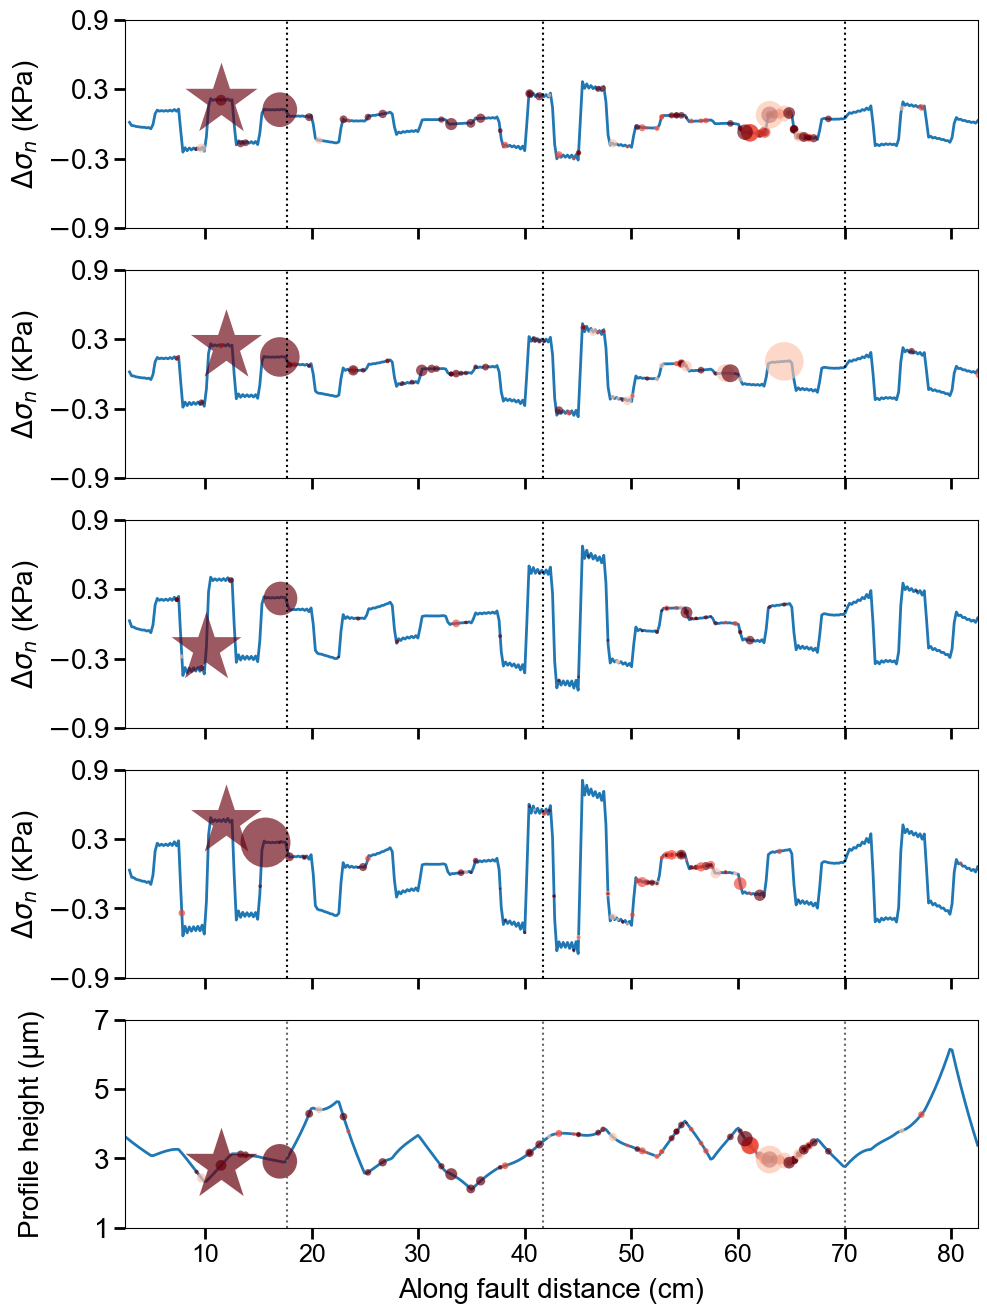

In [252]:
## 截取色谱的部分频段
import matplotlib.colors as colors
import matplotlib as mpl
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )
    return new_cmap

bounds = [-30, -20, -10, 0]
nbin = len(bounds)-1
cmap = plt.get_cmap("Reds")
cmaps = truncate_colormap(cmap, 0.22, 1)
norm = mpl.colors.BoundaryNorm(bounds, cmaps.N)
im = mpl.cm.ScalarMappable(norm=norm, cmap=cmaps)

# cmapName = "copper"
scale_factor = 0.7
fig, ax= plt.subplots(5, 1, figsize=(11,16), dpi=100)
for i in range (4):
    ax[i].plot(x1_ddiff,DeltaSigma_s[i], color="C0", lw=2, zorder=1)
    ax[i].scatter(dists_s[i], z1_diff_s_s[i],  s=areas_s[i]*scale_factor, marker="o",  c=times_s[i], edgecolors="w", lw=0., cmap=cmaps,  norm=norm, alpha=0.65,zorder=2)
    ax[i].scatter( distss_s[i], z1_diff_ss_s[i],  s=areass_s[i]*scale_factor, marker="o", alpha=0.65, c=timess_s[i], edgecolors="w", lw=0., cmap=cmaps, norm=norm,zorder=2)
    ax[i].scatter( distsss_s[i], z1_diff_sss_s[i],  s=areasss_s[i]*scale_factor, marker="o", alpha=0.65, c=timesss_s[i], edgecolors="w", lw=0., cmap=cmaps, norm=norm, zorder=2)
    ax[i].scatter( dist_m_s[i], z1_diff_m_s[i], s=area_m_s[i]*0.9, marker="*", alpha=0.65, c=time_m_s[i], edgecolors="w", lw=0., cmap=cmaps, norm=norm, zorder=2)
    ax[i].set_xlim([2.5, 82.5])
    ax[i].set_ylim([-0.9, 0.9])
    ax[i].yaxis.set_major_locator(MultipleLocator(0.3))
    ax[i].tick_params(axis='both', labelsize=18)
    ax[i].set_ylabel("$\Delta \sigma_n$ (KPa)", fontsize=20,)
    ax[i].set_yticks([-0.9, -0.3, 0.3,  0.9], labels=["$-$0.9", "$-$0.3", "0.3", "0.9"], fontsize=20)
    ax[i].xaxis.set_ticklabels([])
    
    ax[i].axvline(x = 17.7, color = "k", linestyle=':')
    ax[i].axvline(x = 41.7, color = "k", linestyle=':')
    ax[i].axvline(x = 70.0, color = "k", linestyle=':')
    # ax[i].axhline(y = 0.0, color = "k", linestyle='--')

zs= z1[0,:]*1e4
z1_diff_m_0 = linearInterpolate(x1[0,:],zs, dist_m_s[0])
z1_diff_s_0   = linearInterpolate(x1[0,:],zs, dists_s[0])
z1_diff_ss_0  = linearInterpolate(x1[0,:],zs, distss_s[0])
z1_diff_sss_0 = linearInterpolate(x1[0,:],zs, distsss_s[0])

ax[4].plot(x1[0,:], zs,lw=2, zorder=2)
scat=ax[4].scatter(dists_s[0], z1_diff_s_0,  s=areas_s[0]*scale_factor, marker="o", alpha=0.7, c=times_s[0], edgecolors="w", lw=0.5, cmap=cmaps, norm=norm, linewidth=0.1,zorder=2)
ax[4].scatter( distss_s[0], z1_diff_ss_0,  s=areass_s[0]*scale_factor, marker="o", alpha=0.7, c=timess_s[0], edgecolors="w", lw=0.5, cmap=cmaps, norm=norm, linewidth=0.1,zorder=2)
ax[4].scatter( distsss_s[0], z1_diff_sss_0,  s=areasss_s[0]*scale_factor, marker="o", alpha=0.7, c=timesss_s[0], edgecolors="w", lw=0.5, cmap=cmaps, norm=norm, linewidth=0.1,zorder=2)
ax[4].scatter( dist_m_s[0], z1_diff_m_0, s=area_m_s[0]*0.9, marker="*", alpha=0.7, c=time_m_s[0], edgecolors="w", lw=0.5, cmap=cmaps, norm=norm, linewidth=0.1,zorder=2)
ax[4].set_xlim([2.5, 82.5])
ax[4].set_ylim([1, 7])
ax[4].tick_params(axis='both', labelsize=18)
ax[4].set_ylabel("Profile height (µm)", fontsize=20, labelpad=35)
ax[4].set_xlabel("Along fault distance (cm)", fontsize=20, labelpad=8)
ax[4].set_yticks([1, 3, 5,  7], labels=["1", "3", "5", "7"], fontsize=20)
ax[4].axvline(x = 17.7, color = [0.4,0.4,0.4], linestyle=':')
ax[4].axvline(x = 41.7, color = [0.4,0.4,0.4], linestyle=':')
ax[4].axvline(x = 70.0, color = [0.4,0.4,0.4], linestyle=':')
ax[4].axhline(y = 0.0, color = [0.4,0.4,0.4], linestyle=':')

plt.savefig("rsk.png", dpi=600, bbox_inches="tight")